# Network Analysis for BeveL Betaseries 

Inputs: betaseries files for BeveL participants (n=85) drawn from 4 conditions: choice, reward taste, punishment taste, neutral rinse

Analysis workflow is mapped off this paper: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5429248/


### Input Data
- One timeseries txt file per participant. Conditions must be separated in unique folder
- Need a txt file of the labels for each ROI

### Outputs
- Circle graph showing thresholded connectivity of each ROI. ROI color denotes modules. 
- Circle graph of module edge weights. 
- CSV file with module assignment & nodal metrics for each ROI

### Running the notebook
The following parts of the code should be changed
1. Filepath to timeseries 
2. Name of circle graph figure
3. Module dict to assign to module graph
4. Name of module graph figure
5. Name of csv file

## Note: 
### Print Statements are commented out to save time, remove comments if desired. 

In [38]:
# Imports 
import glob
import os
import networkx as nx
import numpy as np
import pandas as pd
import bz2
import pickle
import community
import statistics
import pdb
from scipy import stats
import scipy
import matplotlib
matplotlib.use("Qt5Agg")
import matplotlib.pyplot as plt

from visbrain.objects import ConnectObj, SceneObj, SourceObj, BrainObj, ColorbarObj
from visbrain.io import download_file


In [3]:
basepath = '/Users/jennygilbert/Documents/'

## Load in the data

### Find the path to the data

In [4]:
#Find the path to data
file_list = glob.glob(os.path.join(basepath,'betaseries_bevel/4_combine_timeseries/reward/*.txt'))

In [5]:
#Check the files found
#print(file_list)

In [6]:
#Check to see how many participants 
#len(file_list)

### Make a dictionary to read in the files to pandas

In [7]:
#Setting the ditionary
my_dict={}
for item in file_list:
    name=item.split('/')[7].split('.')[0]
    print(name)
    my_dict.setdefault(name, []).append(item)

sub-001_reward
sub-002_reward
sub-003_reward
sub-004_reward
sub-005_reward
sub-006_reward
sub-007_reward
sub-009_reward
sub-010_reward
sub-011_reward
sub-012_reward
sub-013_reward
sub-014_reward
sub-015_reward
sub-016_reward
sub-017_reward
sub-018_reward
sub-019_reward
sub-020_reward
sub-021_reward
sub-022_reward
sub-024_reward
sub-025_reward
sub-026_reward
sub-027_reward
sub-028_reward
sub-029_reward
sub-030_reward
sub-031_reward
sub-032_reward
sub-033_reward
sub-034_reward
sub-035_reward
sub-036_reward
sub-037_reward
sub-038_reward
sub-039_reward
sub-040_reward
sub-041_reward
sub-042_reward
sub-043_reward
sub-044_reward
sub-045_reward
sub-046_reward
sub-047_reward
sub-048_reward
sub-050_reward
sub-052_reward
sub-053_reward
sub-054_reward
sub-055_reward
sub-056_reward
sub-057_reward
sub-058_reward
sub-059_reward
sub-060_reward
sub-061_reward
sub-062_reward
sub-063_reward
sub-064_reward
sub-066_reward
sub-067_reward
sub-068_reward
sub-069_reward
sub-070_reward
sub-071_reward
sub-072_re

In [8]:
# Checking to make sure its populated
#my_dict['sub-024_reward']

### Read the data from the dictionary into pandas

In [9]:
#Setting the data dictionary
data_dict={}
for key, value in my_dict.items():
    for i in value:
        data_dict.setdefault(key, []).append(pd.read_csv(i, sep='\t' ,header=None,index_col=False))

In [10]:
#Check the dictionary
data_dict.keys()

dict_keys(['sub-001_reward', 'sub-002_reward', 'sub-003_reward', 'sub-004_reward', 'sub-005_reward', 'sub-006_reward', 'sub-007_reward', 'sub-009_reward', 'sub-010_reward', 'sub-011_reward', 'sub-012_reward', 'sub-013_reward', 'sub-014_reward', 'sub-015_reward', 'sub-016_reward', 'sub-017_reward', 'sub-018_reward', 'sub-019_reward', 'sub-020_reward', 'sub-021_reward', 'sub-022_reward', 'sub-024_reward', 'sub-025_reward', 'sub-026_reward', 'sub-027_reward', 'sub-028_reward', 'sub-029_reward', 'sub-030_reward', 'sub-031_reward', 'sub-032_reward', 'sub-033_reward', 'sub-034_reward', 'sub-035_reward', 'sub-036_reward', 'sub-037_reward', 'sub-038_reward', 'sub-039_reward', 'sub-040_reward', 'sub-041_reward', 'sub-042_reward', 'sub-043_reward', 'sub-044_reward', 'sub-045_reward', 'sub-046_reward', 'sub-047_reward', 'sub-048_reward', 'sub-050_reward', 'sub-052_reward', 'sub-053_reward', 'sub-054_reward', 'sub-055_reward', 'sub-056_reward', 'sub-057_reward', 'sub-058_reward', 'sub-059_reward',

In [11]:
#Check for the dataframe
#data_dict['sub-058_reward']

### Create a new dictionary with correlation matrix

In [12]:
#Setting up the correlation dictionary
cor_dict={}

for key, value in data_dict.items():
    value[0]
    #pdb.set_trace()
    cor_matrix = value[0].corr()
    cor_dict[key] = cor_matrix
    

In [13]:
#check the dictionary
#list(cor_dict.values())[3]

### Make a dictionary of labels for the nodes

In [14]:
#This points to a txt file with the ROI names in a list separated by commas
path = os.path.join(basepath,'betaseries_bevel/5_analysis/labels.txt')
df_label = pd.read_csv(path, sep=',')

#df_label.head()

In [15]:
labels_dict = {}
n=0
for item in df_label:
    labels_dict[n]=item
    n=n+1

In [16]:
print(labels_dict)

{0: 'Amygdala_L', 1: 'Amygdala_R', 2: 'Dorsal_striatum_L', 3: 'Dorsal_striatum_R', 4: 'Fusiform_gyrus_L', 5: 'Fusiform_gyrus_R', 6: 'Hippocampus_L', 7: 'Hippocampus_R', 8: 'Insula_L', 9: 'Insula_R', 10: 'Intracalcarine_cortex_L', 11: 'Intracalcarine_cortex_R', 12: 'lOFC_L', 13: 'lOFC_R', 14: 'mOFC_L', 15: 'mOFC_R', 16: 'Oral_somatosensory_cortex_R', 17: 'Oral_somatosensory_cortex_L', 18: 'Precuneus_L', 19: 'Precuneus_R', 20: 'Ventral_striatum_L', 21: 'Ventral_striatum_R', 22: 'vlPFC_L', 23: 'vlPFC_R', 24: 'vlThalamus_L', 25: 'vlThalamus_R', 26: 'vmPFC_L', 27: 'vmPFC_R'}


### Function to create a graph with positive or negative values and minimum correlation value

In [17]:
def create_corr_network_5(G, corr_direction, min_correlation):

    ##Creates a copy of the graph
    H = G.copy()
    
    ##Checks all the edges and removes some based on corr_direction
    for stock1, stock2, weight in list(G.edges(data=True)):
        ##if we only want to see the positive correlations we then delete the edges with weight smaller than 0        
        if corr_direction == "positive":
            ####it adds a minimum value for correlation. 
            ####If correlation weaker than the min, then it deletes the edge
            if weight["weight"] <0 or weight["weight"] < min_correlation:
                H.remove_edge(stock1, stock2)
        ##this part runs if the corr_direction is negative and removes edges with weights equal or largen than 0
        else:
            ####it adds a minimum value for correlation. 
            ####If correlation weaker than the min, then it deletes the edge
            if weight["weight"] >=0 or weight["weight"] > min_correlation:
                H.remove_edge(stock1, stock2)
    return(H)

### Function to make a graph object BY SUBJECT
This will return:
- The edges (noramlized R correlation matrix, in pandas dataframe)
- The correlations (absolute value of the edges in a numpy dataframe)
- The mean_FC (the mean functional connectivity per subject/run)
- The graphs (this will contain the raw graph object G as well as the the partion values from the modularity calculation)
- The modules (communitites in the network at the participant level

## Changes from the First Iteration

1. Test for mean,sd, and module assignment distribution among participant's graphs

In [20]:
def make_graphs(list_o_data, direction, min_cor):
    edge_dict={}
    cor_dict={}
    FC_dict={}
    sd_dict={}
    graph_dict={}
    partition_dict={}
    for key, values in list_o_data.items():
            #i=i.set_index(labels.ID)
            #i.rename(columns=labels.ID, inplace=True)
            ########################################
            edge_dict.setdefault(key, []).append(values)
            ########################################
            cor_matrix = np.asmatrix(values)
            x=abs(cor_matrix)
            mu=x.mean()
            sd=x.std()
            ########################################
            cor_dict.setdefault(key, []).append(x)
            ########################################
            FC_dict.setdefault(key, []).append(mu)
            sd_dict.setdefault(key, []).append(sd)
            ########################################
            G = nx.from_numpy_matrix(cor_matrix)
            #for i, nlrow in labels.iterrows():
                #G.node[i].update(nlrow[0:].to_dict())
            ########################################
            graph_dict.setdefault(key, []).append(G)
            ########################################
            partition = community.best_partition(create_corr_network_5(G, direction,min_cor))
            ########################################
            partition_dict.setdefault(key, []).append(partition)
            ########################################
    return({'edges':edge_dict, 'correlations':cor_dict, 'mean_FC':FC_dict, 'stdev':sd_dict, 'graphs':graph_dict,'modules':partition_dict})

### Apply the function to correlations & check output

In [21]:
# Apply function
GRAPHS = make_graphs(cor_dict, "positive", 0)

In [22]:
# Check the keys for the dictionary
GRAPHS.keys()

dict_keys(['edges', 'correlations', 'mean_FC', 'stdev', 'graphs', 'modules'])

In [23]:
# Check modules for one subject
GRAPHS['stdev']['sub-001_reward']

[0.2073635207034673]

In [140]:
#Check to make sure graphs are filled
#Test = GRAPHS['graphs']['sub-001_reward'][0]
#Test.edges(data=True)

In [24]:
GRAPHS['mean_FC']

{'sub-001_reward': [0.2848602794212194],
 'sub-002_reward': [0.35856202261993647],
 'sub-003_reward': [0.23622929390545463],
 'sub-004_reward': [0.21269017088271103],
 'sub-005_reward': [0.37057148035938847],
 'sub-006_reward': [0.2263212903943031],
 'sub-007_reward': [0.2534808597784768],
 'sub-009_reward': [0.2965987229797016],
 'sub-010_reward': [0.286494156389793],
 'sub-011_reward': [0.49835533845313185],
 'sub-012_reward': [0.3585074814383908],
 'sub-013_reward': [0.3183437385688916],
 'sub-014_reward': [0.24565786120820746],
 'sub-015_reward': [0.29886493927261676],
 'sub-016_reward': [0.3111134721329929],
 'sub-017_reward': [0.27933232701441335],
 'sub-018_reward': [0.26954354391005303],
 'sub-019_reward': [0.2605883787686915],
 'sub-020_reward': [0.2509311019470671],
 'sub-021_reward': [0.21474761152305286],
 'sub-022_reward': [0.2552437366975302],
 'sub-024_reward': [0.2531467778227901],
 'sub-025_reward': [0.2682607227565468],
 'sub-026_reward': [0.26854081462923146],
 'sub-

### Get the standard deviation of the mean correlation

In [25]:
#statistics.stdev(GRAPHS['mean_FC'])
m=[]

for key,value in GRAPHS['mean_FC'].items():
    m.append(value[0])

In [30]:
#describe the mean correlation of participant's graphs
stats.describe(m)

DescribeResult(nobs=85, minmax=(0.20383900223774987, 0.5166211767218827), mean=0.30456663895510727, variance=0.00413335833745449, skewness=1.1011435443430952, kurtosis=1.4490091512477061)

In [27]:
statistics.mean(m)

0.30456663895510727

In [57]:
m

[0.2848602794212194,
 0.35856202261993647,
 0.23622929390545463,
 0.21269017088271103,
 0.37057148035938847,
 0.2263212903943031,
 0.2534808597784768,
 0.2965987229797016,
 0.286494156389793,
 0.49835533845313185,
 0.3585074814383908,
 0.3183437385688916,
 0.24565786120820746,
 0.29886493927261676,
 0.3111134721329929,
 0.27933232701441335,
 0.26954354391005303,
 0.2605883787686915,
 0.2509311019470671,
 0.21474761152305286,
 0.2552437366975302,
 0.2531467778227901,
 0.2682607227565468,
 0.26854081462923146,
 0.4087092701281954,
 0.2064481890269867,
 0.25536399057669185,
 0.30401885920967797,
 0.34980383366628465,
 0.23256744034878715,
 0.27804698772816977,
 0.33676209376527194,
 0.2511652398528155,
 0.2853068206610137,
 0.29697142305770025,
 0.3776642351109596,
 0.21917925287754073,
 0.2637785299819304,
 0.2300062603870038,
 0.3113557640743733,
 0.34631155512462036,
 0.4512244868545139,
 0.4037509712670373,
 0.3751469738137319,
 0.27888314709246814,
 0.22649027734012997,
 0.2873331183

In [56]:
#Show the histogram of average correlation across participant's graphs

hist, bin_edges = scipy.histogram(m, bins = 10) 
  
# Checking the results 
print ("No. of points in each bin : ", hist) 
print ("Size of the bins          : ", bin_edges) 
  
# plotting the histogram 
plt.bar(bin_edges[:-1], hist, width = .1) 
plt.xlim(min(bin_edges), max(bin_edges)) 
plt.show() 

No. of points in each bin :  [10 12 23 17  9  7  3  1  0  3]
Size of the bins          :  [0.203839   0.23511722 0.26639544 0.29767365 0.32895187 0.36023009
 0.39150831 0.42278652 0.45406474 0.48534296 0.51662118]


### Get the mean SD of participant's corrleation matricies

In [32]:
sd=[]
for key,value in GRAPHS['stdev'].items():
    sd.append(value[0])

In [33]:
#describe the mean correlation of participant's graphs
stats.describe(sd)

DescribeResult(nobs=85, minmax=(0.1936001322707724, 0.3146723695461026), mean=0.22438820713991522, variance=0.0005766317185922301, skewness=1.7884612319790045, kurtosis=3.3764391902152617)

In [35]:
sd

[0.2073635207034673,
 0.2733026006923,
 0.2116172710089582,
 0.20231125522696475,
 0.2410264565999763,
 0.2120057561819862,
 0.2000880855674745,
 0.21406337214449028,
 0.20149595349917296,
 0.309505192889523,
 0.2146746901387391,
 0.23344361962899463,
 0.22307271138356988,
 0.2273662366620012,
 0.22307133204233248,
 0.20093487440776553,
 0.20607379509819654,
 0.21540642700392532,
 0.21265325875708518,
 0.2079075807873622,
 0.21230339323069403,
 0.21517966564281107,
 0.20941222038440507,
 0.22469549026727342,
 0.27727457736067507,
 0.19784963281008813,
 0.21037875419566252,
 0.21849367670830655,
 0.23960716483777042,
 0.1994663401962697,
 0.20923784251926192,
 0.21361819146886052,
 0.20558676612867494,
 0.21596321561875687,
 0.21315010665209583,
 0.26311495624365044,
 0.20759117685554077,
 0.21720824572372158,
 0.20608522182753589,
 0.20151171472685883,
 0.21219636837457945,
 0.2134112529738157,
 0.24373894038860436,
 0.26613047822167124,
 0.2275896737124343,
 0.204328522747463,
 0.2175

In [55]:
hist, bin_edges = scipy.histogram(sd, bins = 10) 
  
# Checking the results 
print ("No. of points in each bin : ", hist) 
print ("Size of the bins          : ", bin_edges) 
  
# plotting the histogram 
plt.bar(bin_edges[:-1], hist, width = .05) 
plt.xlim(min(bin_edges), max(bin_edges)) 
plt.show() 

No. of points in each bin :  [14 31 17 11  3  3  2  2  0  2]
Size of the bins          :  [0.19360013 0.20570736 0.21781458 0.2299218  0.24202903 0.25413625
 0.26624347 0.2783507  0.29045792 0.30256515 0.31467237]


If this value is low (<0.1) then you don't need to threshold the graph? 

### Test Modularity

Goal: use modularity function from communities to identify module structure that emerge during reward within the sample

In [58]:
#this is pulling out the module structure for each participant
modules=[]

for key,value in GRAPHS['modules'].items():
    modules.append(value[0])

In [59]:
#print it to make sure it works
modules

[{0: 0,
  1: 1,
  2: 2,
  3: 3,
  4: 4,
  5: 4,
  6: 0,
  7: 0,
  8: 1,
  9: 1,
  10: 4,
  11: 4,
  12: 4,
  13: 1,
  14: 4,
  15: 4,
  16: 2,
  17: 2,
  18: 1,
  19: 1,
  20: 5,
  21: 5,
  22: 1,
  23: 2,
  24: 1,
  25: 1,
  26: 5,
  27: 2},
 {0: 0,
  1: 0,
  2: 1,
  3: 1,
  4: 2,
  5: 2,
  6: 0,
  7: 0,
  8: 1,
  9: 1,
  10: 2,
  11: 2,
  12: 3,
  13: 3,
  14: 2,
  15: 2,
  16: 1,
  17: 1,
  18: 4,
  19: 4,
  20: 4,
  21: 4,
  22: 1,
  23: 1,
  24: 0,
  25: 0,
  26: 1,
  27: 1},
 {0: 0,
  1: 0,
  2: 1,
  3: 1,
  4: 2,
  5: 2,
  6: 0,
  7: 0,
  8: 3,
  9: 3,
  10: 3,
  11: 3,
  12: 3,
  13: 4,
  14: 2,
  15: 2,
  16: 3,
  17: 3,
  18: 4,
  19: 3,
  20: 0,
  21: 0,
  22: 1,
  23: 5,
  24: 4,
  25: 1,
  26: 2,
  27: 1},
 {0: 0,
  1: 0,
  2: 1,
  3: 1,
  4: 2,
  5: 3,
  6: 0,
  7: 0,
  8: 4,
  9: 4,
  10: 3,
  11: 3,
  12: 4,
  13: 0,
  14: 2,
  15: 2,
  16: 1,
  17: 1,
  18: 0,
  19: 5,
  20: 1,
  21: 1,
  22: 6,
  23: 6,
  24: 4,
  25: 4,
  26: 1,
  27: 1},
 {0: 0,
  1: 0,
  2: 1,
  3:

In [60]:
#made a df of the modules
df = pd.DataFrame.from_dict(modules)

In [61]:
df

,0,1,2,3,4,5,6,7,8,9,...,18,19,20,21,22,23,24,25,26,27
0,0,1,2,3,4,4,0,0,1,1,...,1,1,5,5,1,2,1,1,5,2
1,0,0,1,1,2,2,0,0,1,1,...,4,4,4,4,1,1,0,0,1,1
2,0,0,1,1,2,2,0,0,3,3,...,4,3,0,0,1,5,4,1,2,1
3,0,0,1,1,2,3,0,0,4,4,...,0,5,1,1,6,6,4,4,1,1
4,0,0,1,1,2,2,0,0,1,3,...,2,4,4,4,1,1,2,2,1,1
5,0,1,2,2,3,4,3,3,0,0,...,4,4,2,2,1,1,0,0,3,3
6,0,0,1,1,2,3,0,0,2,3,...,3,1,0,0,4,4,0,5,2,4
7,0,0,1,2,3,3,0,0,3,3,...,5,5,2,2,2,2,3,3,2,2
8,0,1,2,2,1,0,0,1,3,4,...,0,4,6,4,6,6,3,3,6,4
9,0,0,1,1,0,1,0,0,1,1,...,0,1,2,0,0,0,0,2,0,1


In [64]:
#label the modules
df.rename(columns={0:"Amygdala_L",1:"Amygdala_R", 2:"Dorsal_striatum_L", 3:"Dorsal_striatum_R", 4:"Fusiform_gyrus_L", 5:"Fusiform_gyrus_R", 6:"Hippocampus_L", 7:"Hippocampus_R", 8:"Insula_L",
          9:"Insula_R", 10:"Intracalcarine_cortex_L", 11:"Intracalcarine_cortex_R", 12:"lOFC_L", 13: "lOFC_R", 14: "mOFC_L", 15:"mOFC_R", 16:"Oral_somatosensory_cortex_R", 17:"Oral_somatosensory_cortex_L", 18:"Precuneus_L", 
          19:"Precuneus_R", 20:"Ventral_striatum_L", 21:"Ventral_striatum_R", 22:"vlPFC_L", 23:"vlPFC_R", 24:"vlThalamus_L" , 25:"vlThalamus_R", 26: "vmPFC_L", 27: "vmPFC_R"})

,Amygdala_L,Amygdala_R,Dorsal_striatum_L,Dorsal_striatum_R,Fusiform_gyrus_L,Fusiform_gyrus_R,Hippocampus_L,Hippocampus_R,Insula_L,Insula_R,...,Precuneus_L,Precuneus_R,Ventral_striatum_L,Ventral_striatum_R,vlPFC_L,vlPFC_R,vlThalamus_L,vlThalamus_R,vmPFC_L,vmPFC_R
0,0,1,2,3,4,4,0,0,1,1,...,1,1,5,5,1,2,1,1,5,2
1,0,0,1,1,2,2,0,0,1,1,...,4,4,4,4,1,1,0,0,1,1
2,0,0,1,1,2,2,0,0,3,3,...,4,3,0,0,1,5,4,1,2,1
3,0,0,1,1,2,3,0,0,4,4,...,0,5,1,1,6,6,4,4,1,1
4,0,0,1,1,2,2,0,0,1,3,...,2,4,4,4,1,1,2,2,1,1
5,0,1,2,2,3,4,3,3,0,0,...,4,4,2,2,1,1,0,0,3,3
6,0,0,1,1,2,3,0,0,2,3,...,3,1,0,0,4,4,0,5,2,4
7,0,0,1,2,3,3,0,0,3,3,...,5,5,2,2,2,2,3,3,2,2
8,0,1,2,2,1,0,0,1,3,4,...,0,4,6,4,6,6,3,3,6,4
9,0,0,1,1,0,1,0,0,1,1,...,0,1,2,0,0,0,0,2,0,1


# Plot the distibution of module assignments for the ROIs

<IPython.core.display.Javascript object>


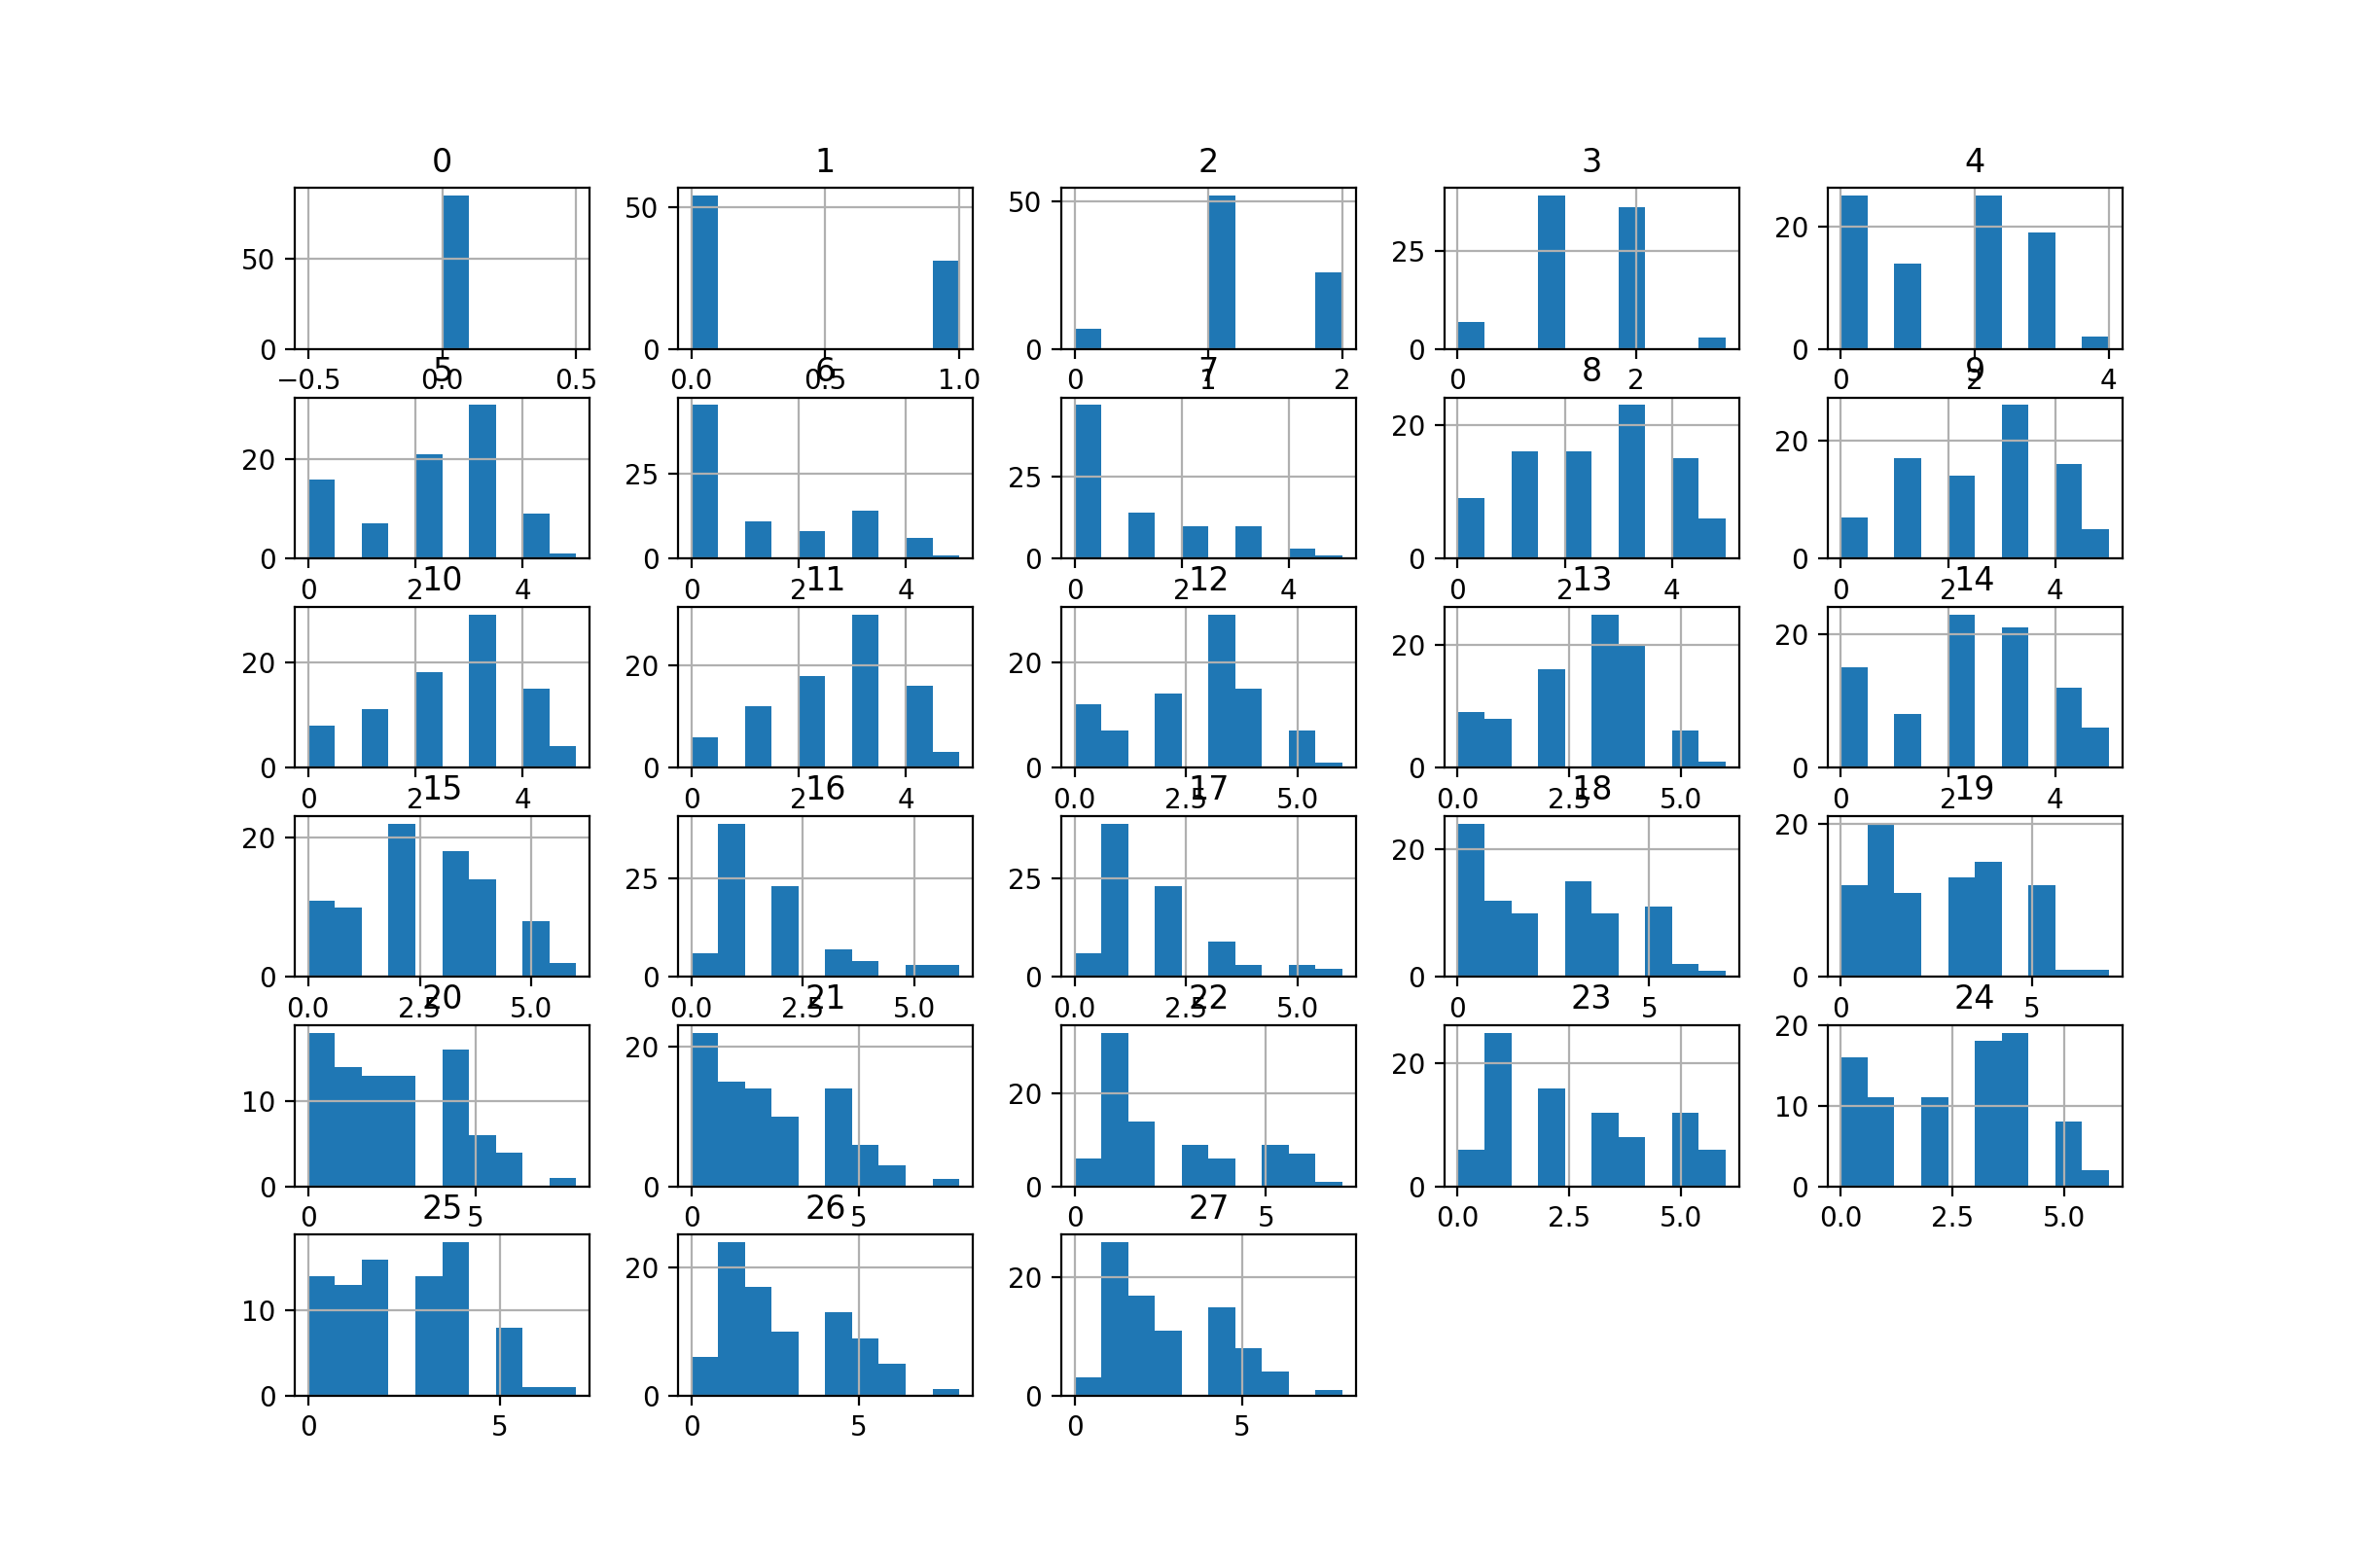

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c1e73d588>,
      dtype=object)

In [86]:
df.hist()

### Only a couple ROI have stable module assignment -- modules 0, 1, and 2 
- 0:"Amygdala_L"
- 1:"Amygdala_R"
- 2:"Dorsal_striatum_L"

In [79]:
#find the mean over the columns
df.mean(axis = 0)

0     0.000000
1     0.364706
2     1.223529
3     1.411765
4     1.517647
5     2.152941
6     1.152941
7     0.952941
8     2.435294
9     2.494118
10    2.517647
11    2.552941
12    2.623529
13    2.717647
14    2.294118
15    2.541176
16    1.823529
17    1.776471
18    2.247059
19    2.517647
20    2.411765
21    2.176471
22    2.423529
23    2.600000
24    2.529412
25    2.494118
26    2.623529
27    2.647059
dtype: float64

In [80]:
# Check the standard deviation over the columns
df.std(axis = 0)

0     0.000000
1     0.484204
2     0.585061
3     0.695121
4     1.201306
5     1.313899
6     1.451648
7     1.290126
8     1.434665
9     1.376880
10    1.314858
11    1.248865
12    1.503777
13    1.444297
14    1.478606
15    1.570206
16    1.373009
17    1.285232
18    1.932836
19    1.783601
20    1.897957
21    1.903483
22    1.866857
23    1.780851
24    1.722320
25    1.715639
26    1.805919
27    1.709260
dtype: float64



## The standard deviation of module assignments is high (>1) for the majority of the modules. 

### This suggests the module assignment is not stable across participants 

### Using the median module assignment across participants makes more sense than the mean

In [152]:
#find the mean over the columns
partition_median = df.median()
df_median = pd.DataFrame(partition_median)

In [153]:
# View the median module for each node
df_median

### Make a Dicitionary with the modules

In [154]:
#Convert modules to dictionary
#mod_dict={}
#for index, row in df_median.iterrows():
    #mod_dict[index]= row[0]

#mod_dict

### Combine participant correlation matrices into one mean correlation matrix

In [87]:
#make the function to combine
def make_total_graphs(dict_o_data):
    mylist=[]
    for key, val_list in dict_o_data.items():
        for i in val_list:
            cor_matrix = np.asarray(i)
            mylist.append(cor_matrix)
    x=np.stack(mylist, axis=2)
    mu=np.median(x, axis=(2))
    return(mu)

In [88]:
#Make the mean graph with correlations
mean_graph = make_total_graphs(GRAPHS['correlations'])

In [89]:
#Check to make sure this worked 
print(mean_graph.shape)

#Convert the graph to a numpy matrix so it can be recognized by networkX
mean_graph_mat = np.matrix(mean_graph)

#Check the mean correlation to use to threshold later
mean_graph_mat.mean()

(28, 28)


0.2832574556194909

In [90]:
meanG = nx.from_numpy_matrix(mean_graph_mat)

# Check Modularity in the Mean Graph

### This is the way Cohen's group usually calculates modularity, because its more stable

In [91]:
partition = community.best_partition(meanG)

In [92]:
#Add the modules and ROI labels to the graph
nx.set_node_attributes(meanG, partition, 'modules')
nx.set_node_attributes(meanG, labels_dict, 'ROIs')

In [93]:
# Check to make sure this worked
ROIs=nx.get_node_attributes(meanG,'ROIs')
ROIs

{0: 'Amygdala_L',
 1: 'Amygdala_R',
 2: 'Dorsal_striatum_L',
 3: 'Dorsal_striatum_R',
 4: 'Fusiform_gyrus_L',
 5: 'Fusiform_gyrus_R',
 6: 'Hippocampus_L',
 7: 'Hippocampus_R',
 8: 'Insula_L',
 9: 'Insula_R',
 10: 'Intracalcarine_cortex_L',
 11: 'Intracalcarine_cortex_R',
 12: 'lOFC_L',
 13: 'lOFC_R',
 14: 'mOFC_L',
 15: 'mOFC_R',
 16: 'Oral_somatosensory_cortex_R',
 17: 'Oral_somatosensory_cortex_L',
 18: 'Precuneus_L',
 19: 'Precuneus_R',
 20: 'Ventral_striatum_L',
 21: 'Ventral_striatum_R',
 22: 'vlPFC_L',
 23: 'vlPFC_R',
 24: 'vlThalamus_L',
 25: 'vlThalamus_R',
 26: 'vmPFC_L',
 27: 'vmPFC_R'}

In [94]:
#Check if this worked
partitions=nx.get_node_attributes(meanG,'modules')
partitions

{0: 0,
 1: 0,
 2: 1,
 3: 1,
 4: 2,
 5: 3,
 6: 0,
 7: 0,
 8: 4,
 9: 4,
 10: 3,
 11: 3,
 12: 3,
 13: 3,
 14: 2,
 15: 2,
 16: 1,
 17: 1,
 18: 5,
 19: 5,
 20: 6,
 21: 6,
 22: 1,
 23: 1,
 24: 4,
 25: 4,
 26: 1,
 27: 1}

# NOW: Check if mean partitioned graph is more stable than individually partitioned median modules 








In [ ]:
#Apply the partition to participant's data

modg = community.induced_graph(partitions, meanG) 

### Function to make a thresholded graph

In [164]:
def threshold(G, corr_direction, min_correlation):

    ##Creates a copy of the graph
    H = G.copy()
    
    ##Checks all the edges and removes some based on corr_direction
    for stock1, stock2, weight in list(G.edges(data=True)):
        ##if we only want to see the positive correlations we then delete the edges with weight smaller than 0        
        if corr_direction == "positive":
            ####it adds a minimum value for correlation. 
            ####If correlation weaker than the min, then it deletes the edge
            if weight["weight"] <0 or weight["weight"] < min_correlation:
                H.remove_edge(stock1, stock2)
        ##this part runs if the corr_direction is negative and removes edges with weights equal or largen than 0
        else:
            ####it adds a minimum value for correlation. 
            ####If correlation weaker than the min, then it deletes the edge
            if weight["weight"] >=0 or weight["weight"] > min_correlation:
                H.remove_edge(stock1, stock2)
    return(H)

In [165]:
threshG = threshold(meanG, 'positive', 0.3)

In [166]:
meanG.nodes(data=True)

NodeDataView({0: {'modules': 0, 'ROIs': 'Amygdala_L'}, 1: {'modules': 0, 'ROIs': 'Amygdala_R'}, 2: {'modules': 1, 'ROIs': 'Dorsal_striatum_L'}, 3: {'modules': 1, 'ROIs': 'Dorsal_striatum_R'}, 4: {'modules': 2, 'ROIs': 'Fusiform_gyrus_L'}, 5: {'modules': 3, 'ROIs': 'Fusiform_gyrus_R'}, 6: {'modules': 0, 'ROIs': 'Hippocampus_L'}, 7: {'modules': 0, 'ROIs': 'Hippocampus_R'}, 8: {'modules': 4, 'ROIs': 'Insula_L'}, 9: {'modules': 4, 'ROIs': 'Insula_R'}, 10: {'modules': 3, 'ROIs': 'Intracalcarine_cortex_L'}, 11: {'modules': 3, 'ROIs': 'Intracalcarine_cortex_R'}, 12: {'modules': 5, 'ROIs': 'lOFC_L'}, 13: {'modules': 5, 'ROIs': 'lOFC_R'}, 14: {'modules': 2, 'ROIs': 'mOFC_L'}, 15: {'modules': 2, 'ROIs': 'mOFC_R'}, 16: {'modules': 1, 'ROIs': 'Oral_somatosensory_cortex_R'}, 17: {'modules': 1, 'ROIs': 'Oral_somatosensory_cortex_L'}, 18: {'modules': 6, 'ROIs': 'Precuneus_L'}, 19: {'modules': 6, 'ROIs': 'Precuneus_R'}, 20: {'modules': 7, 'ROIs': 'Ventral_striatum_L'}, 21: {'modules': 7, 'ROIs': 'Vent

### Function to visualize thresholded graph with modules in colors

In [167]:
def jenny_graph(graph):
    edges,weights = zip(*nx.get_edge_attributes(graph, 'weight').items())
    nodes, color = zip(*nx.get_node_attributes(graph,'modules').items()) #if your modules are named different change here
    nodes, positions = zip(*nx.get_node_attributes(graph,'ROIs').items())
    #positions
    positions=nx.circular_layout(graph) #this is defining a circluar graph, if you want a different one you change the circular part of this line
    
    #Figure size
    plt.figure(figsize=(40,25))
    
    
    #draws nodes
    color = np.array(color)
    nColormap=plt.cm.Spectral #check here if you want different colors https://matplotlib.org/3.1.1/gallery/color/colormap_reference.html
    cM=color.max()
    cm=color.min()
    y=nx.draw_networkx_nodes(graph,positions, 
                           node_color=color,
                           node_size=4000,
                           alpha=0.8, 
                           cmap= nColormap,
                           vmin=cm ,vmax=cM)

    #Styling for labels
    nx.draw_networkx_labels(graph, positions, labels = ROIs, font_size=10, 
                            font_family='sans-serif', fontweight = 'bold')
    
    
    #draw edges
    weights=np.array(weights)
    eColormap=plt.cm.bwr #check here if you want different colors https://matplotlib.org/3.1.1/gallery/color/colormap_reference.html
    wt=weights*5
    M=wt.max()
    m=wt.min()
    x=nx.draw_networkx_edges(graph, positions, edge_list=edges, style='solid', width = wt, edge_color = wt,
                           cmap=eColormap,
                           edge_vmin=m,
                           edge_vmax=M)
    
    #format the colorbar
    node_bar=plt.colorbar(y)
    edge_bar=plt.colorbar(x)

    node_bar.set_label('Modularity',fontsize = 25)
    edge_bar.set_label('Strength of edge weight',fontsize = 25)

    plt.axis('off')
    plt.title("Modularity and Edge Weights of Average Graph", fontsize = 30)
    #plt.savefig(os.path.join(basepath,"betaseries_bevel/5_analysis/modularity_circle_reward.png", format="PNG")
    plt.show()

In [168]:
jenny_graph(threshG)

### Make Module Graph with Nodes Weighted by Clustering Coefficient

Make a new graph with modules from whole group analysis 

In [169]:
modg = community.induced_graph(partitions, meanG)

In [170]:
#Clustering coeff multiplied by 2000 -- so the size works with networkx node sizing
#reward_clust_dict = {
    #0.0: 1200,
    #1.0: 1320,
    #2.0: 1360,
    #3.0: 1160,
#}

#punish_clust_dict = {
    #0.0: 1200,
    #1.0: 1280,
    #2.0: 1240,
    #3.0: 1300
#}

In [171]:
#Set module attributes**** Need to change this depending on the condition

#REWARD
#nx.set_node_attributes(modg, reward_clust_dict, 'clustering')

#PUNISHMENT
#nx.set_node_attributes(modg, punish_clust_dict, 'clustering')

In [172]:
#list(modg.nodes)

### Function to make module structure graph

In [173]:
def module_fig(G):
    edges,weights = zip(*nx.get_edge_attributes(G,'weight').items())
    #nodes, size = zip(*nx.get_node_attributes(G,'clustering').items())
    
    
    positions=nx.circular_layout(G)
    plt.figure(figsize=(25,20))
    
    color = np.array(list(G.nodes))
    nColormap=plt.cm.Spectral #check here if you want different colors https://matplotlib.org/3.1.1/gallery/color/colormap_reference.html
    cM=color.max()
    cm=color.min()
    nx.draw_networkx_nodes(G,positions, 
                           node_color=color, 
                           #node_size=size,
                           alpha=1.0, 
                           cmap= 'Spectral',
                           vmin=cm,vmax=cM )
   
    #Styling for labels
    nx.draw_networkx_labels(G, positions, font_size=8, font_family='sans-serif')
    
    x=nx.draw_networkx_edges(G, positions, edge_list=edges,style='solid', width = weights, edge_color = weights)
   
    edge_bar=plt.colorbar(x)
    edge_bar.set_label('Strength of edge weight',fontsize = 25)
    
    plt.title("Module Connectivity Weights", fontsize = 30)
    #plt.savefig(os.path.join(basepath,"betaseries_bevel/5_analysis/results/modularity_edges_reward_weighted.png"), format="PNG")
    plt.axis('off')
    plt.show()

In [174]:
module_fig(modg)

### Calculate Nodal Metrics by Participant
- Clustering Coefficient
- Betweenness centrality

Function to pull the nodal parameters by subject

In [175]:
def make_node_stats(list_o_data, direction, min_cor):
    clustering_dict ={}
    centrality_dict ={}
    
    
    for key, values in list_o_data.items():
            ########################################
            cor_matrix = np.asmatrix(values)
            x=abs(cor_matrix)
            mu=x.mean()
            ########################################
            G = nx.from_numpy_matrix(cor_matrix)
            tG = create_corr_network_5(G, direction,min_cor)
            ########################################
            clustering = nx.clustering(tG, weight=True)
            ########################################
            clustering_dict.setdefault(key, []).append(clustering)
            ########################################
            centrality = nx.betweenness_centrality(tG, weight=True)
            ########################################
            centrality_dict.setdefault(key, []).append(centrality)
            ########################################
    return({'clustering_coeff':clustering_dict, 'btn_centrality':centrality_dict})

In [176]:
#Metrics computed on an UNTHRESHOLDED GRAPH
nodes = make_node_stats(cor_dict, "positive", 0)

In [177]:
nodes.keys()

dict_keys(['clustering_coeff', 'btn_centrality'])

In [178]:
#nodes['btn_centrality']['sub-001_reward']

In [179]:
clustering_coeff=[]

for key,value in nodes['clustering_coeff'].items():
    clustering_coeff.append(value[0])

In [180]:
#bring into pandas
df_clust = pd.DataFrame.from_dict(clustering_coeff)

In [181]:
#Calculate average module centrality
df_clust['module0_mean'] = df_clust[[0,1,6,7]].mean(axis=1)
df_clust['module1_mean'] = df_clust[[2,3,16,17]].mean(axis=1)
df_clust['module2_mean'] = df_clust[[4,14,15]].mean(axis=1)
df_clust['module3_mean'] = df_clust[[5,10,11]].mean(axis=1)
df_clust['module4_mean'] = df_clust[[8,9,24,25]].mean(axis=1)
df_clust['module5_mean'] = df_clust[[12,13]].mean(axis=1)
df_clust['module6_mean'] = df_clust[[18,19]].mean(axis=1)
df_clust['module7_mean'] = df_clust[[20,21]].mean(axis=1)
df_clust['module8_mean'] = df_clust[[22,23,26,27]].mean(axis=1)

In [182]:

df_clust.rename(columns={0:"Amygdala_L",1:"Amygdala_R", 2:"Dorsal_striatum_L", 3:"Dorsal_striatum_R", 4:"Fusiform_gyrus_L", 5:"Fusiform_gyrus_R", 6:"Hippocampus_L", 7:"Hippocampus_R", 8:"Insula_L",
          9:"Insula_R", 10:"Intracalcarine_cortex_L", 11:"Intracalcarine_cortex_R", 12:"lOFC_L", 13: "lOFC_R", 14: "mOFC_L", 15:"mOFC_R", 16:"Oral_somatosensory_cortex_L", 17:"Oral_somatosensory_cortex_R", 18:"Precuneus_L", 
          19:"Precuneus_R", 20:"Ventral_striatum_L", 21:"Ventral_striatum_R", 22:"vlPFC_L", 23:"vlPFC_R", 24:"vlThalamus_L" , 25:"vlThalamus_R", 26: "vmPFC_L", 27: "vmPFC_R"})

,Amygdala_L,Amygdala_R,Dorsal_striatum_L,Dorsal_striatum_R,Fusiform_gyrus_L,Fusiform_gyrus_R,Hippocampus_L,Hippocampus_R,Insula_L,Insula_R,...,vmPFC_R,module0_mean,module1_mean,module2_mean,module3_mean,module4_mean,module5_mean,module6_mean,module7_mean,module8_mean
0,0.964912,0.952569,0.926154,0.926154,0.886667,0.940000,0.936842,0.926154,0.960145,0.949275,...,0.934783,0.945119,0.928077,0.883947,0.923077,0.954295,0.900413,0.936923,0.899671,0.934718
1,0.897436,0.897436,0.981884,0.923077,0.952569,0.983333,0.897436,0.897436,0.946667,0.923077,...,0.981884,0.897436,0.961609,0.944019,0.969302,0.921795,0.975770,0.911795,0.915769,0.934295
2,0.907692,0.905797,0.910000,0.907692,0.894928,0.909524,0.948052,0.926667,0.943723,0.884058,...,0.931159,0.922052,0.891575,0.898132,0.930865,0.914373,0.871282,0.877800,0.907179,0.899027
3,0.810277,0.844156,0.852814,0.842105,0.746667,0.786765,0.766667,0.786765,0.786667,0.878947,...,0.807971,0.801966,0.844650,0.780686,0.735271,0.820213,0.817143,0.857800,0.810845,0.834086
4,0.952899,0.930736,0.946667,0.946667,0.923077,0.945652,0.891738,0.923077,0.891738,0.934066,...,0.978947,0.924612,0.923960,0.907265,0.939115,0.909400,0.946311,0.947840,0.909930,0.921375
5,0.835498,0.786561,0.775362,0.819048,0.847953,0.779412,0.806324,0.842105,0.795238,0.790514,...,0.785714,0.817622,0.805117,0.736782,0.792160,0.815465,0.695040,0.672386,0.878947,0.792100
6,0.903333,0.928105,0.876667,0.930736,0.851852,0.851852,0.883333,0.884058,0.876667,0.903333,...,0.898551,0.899707,0.888746,0.879506,0.881984,0.900594,0.873261,0.887446,0.907444,0.925466
7,0.988304,0.926154,0.914530,0.914530,0.914530,0.963333,0.926154,0.944615,0.944615,0.914530,...,0.980952,0.946307,0.924231,0.934587,0.940826,0.932991,0.935836,0.961999,0.961667,0.955634
8,0.928105,0.924901,0.903333,0.903333,0.886667,0.846154,0.826667,0.938095,0.952381,0.870769,...,0.870769,0.904442,0.895082,0.900858,0.862564,0.897811,0.905290,0.808810,0.884001,0.886659
9,0.981818,0.939394,1.000000,1.000000,0.750000,0.950000,0.752381,0.689474,0.904412,0.869281,...,1.000000,0.840767,1.000000,0.769298,0.812918,0.812471,0.837045,0.868554,0.656470,0.832385


In [183]:
central=[]

for key,value in nodes['btn_centrality'].items():
    central.append(value[0])

In [184]:
df_cent = pd.DataFrame.from_dict(central)

In [185]:
#Calculate average module centrality
df_cent['module0_mean'] = df_cent[[0,1,6,7]].mean(axis=1)
df_cent['module1_mean'] = df_cent[[2,3,16,17]].mean(axis=1)
df_cent['module2_mean'] = df_cent[[4,14,15]].mean(axis=1)
df_cent['module3_mean'] = df_cent[[5,10,11]].mean(axis=1)
df_cent['module4_mean'] = df_cent[[8,9,24,25]].mean(axis=1)
df_cent['module5_mean'] = df_cent[[12,13]].mean(axis=1)
df_cent['module6_mean'] = df_cent[[18,19]].mean(axis=1)
df_cent['module7_mean'] = df_cent[[20,21]].mean(axis=1)
df_cent['module8_mean'] = df_cent[[22,23,26,27]].mean(axis=1)

In [186]:
#rename_columns
df_cent.rename(columns={0:"Amygdala_L",1:"Amygdala_R", 2:"Dorsal_striatum_L", 3:"Dorsal_striatum_R", 4:"Fusiform_gyrus_L", 5:"Fusiform_gyrus_R", 6:"Hippocampus_L", 7:"Hippocampus_R", 8:"Insula_L",
          9:"Insula_R", 10:"Intracalcarine_cortex_L", 11:"Intracalcarine_cortex_R", 12:"lOFC_L", 13: "lOFC_R", 14: "mOFC_L", 15:"mOFC_R", 16:"Oral_somatosensory_cortex_L", 17:"Oral_somatosensory_cortex_R", 18:"Precuneus_L", 
          19:"Precuneus_R", 20:"Ventral_striatum_L", 21:"Ventral_striatum_R", 22:"vlPFC_L", 23:"vlPFC_R", 24:"vlThalamus_L" , 25:"vlThalamus_R", 26: "vmPFC_L", 27: "vmPFC_R"})

,Amygdala_L,Amygdala_R,Dorsal_striatum_L,Dorsal_striatum_R,Fusiform_gyrus_L,Fusiform_gyrus_R,Hippocampus_L,Hippocampus_R,Insula_L,Insula_R,...,vmPFC_R,module0_mean,module1_mean,module2_mean,module3_mean,module4_mean,module5_mean,module6_mean,module7_mean,module8_mean
0,0.000789,0.001690,0.003480,0.003480,0.008783,0.002576,0.001665,0.003480,0.001429,0.001925,...,0.002592,0.001906,0.003288,0.009220,0.004877,0.001714,0.007077,0.005134,0.006183,0.003949
1,0.006720,0.006720,0.000642,0.004504,0.002035,0.000248,0.006720,0.006720,0.002874,0.004504,...,0.000642,0.006720,0.001949,0.002830,0.001185,0.004732,0.000547,0.005446,0.004885,0.003790
2,0.004455,0.003935,0.004052,0.004455,0.005795,0.004233,0.001656,0.003073,0.001836,0.006385,...,0.002670,0.003280,0.005872,0.005080,0.002826,0.003807,0.008242,0.003913,0.004331,0.004920
3,0.009967,0.007100,0.006419,0.005458,0.023450,0.009876,0.016475,0.010092,0.013988,0.004185,...,0.010879,0.010909,0.006524,0.015997,0.006637,0.009895,0.008980,0.004459,0.011727,0.007928
4,0.001819,0.002568,0.002249,0.002249,0.003869,0.002266,0.006722,0.003869,0.006722,0.000896,...,0.000519,0.003744,0.004080,0.005116,0.002698,0.004539,0.002511,0.001567,0.004689,0.004458
5,0.008603,0.013332,0.016173,0.009286,0.006328,0.010547,0.011801,0.006998,0.014492,0.013329,...,0.013581,0.010184,0.011941,0.006592,0.008821,0.010987,0.025817,0.009980,0.004725,0.011990
6,0.004657,0.001739,0.006972,0.002808,0.010102,0.010102,0.006223,0.005761,0.006923,0.004657,...,0.005125,0.004595,0.005998,0.006994,0.006996,0.005089,0.007062,0.004703,0.003824,0.003068
7,0.000271,0.004267,0.005198,0.005198,0.005198,0.001572,0.004163,0.002688,0.002688,0.005198,...,0.000600,0.002847,0.004424,0.003524,0.003152,0.003702,0.003430,0.001282,0.001664,0.002198
8,0.002327,0.003178,0.004931,0.004931,0.006437,0.004765,0.014503,0.002133,0.001659,0.008036,...,0.008036,0.005535,0.006434,0.006188,0.006946,0.006417,0.004921,0.003220,0.006519,0.007882
9,0.000237,0.001367,0.000000,0.000000,0.014676,0.001897,0.011905,0.028131,0.004211,0.006607,...,0.000000,0.010410,0.000000,0.016471,0.020244,0.012274,0.009360,0.007414,0.051259,0.019040


Save out to CSV files

In [187]:
df_clust.to_csv(os.path.join(basepath,'betaseries_bevel/5_analysis/node_clustering_punish_weighted.csv'), header = True, index = None)

In [188]:
df_cent.to_csv(os.path.join(basepath,'betaseries_bevel/5_analysis/node_centrality_punish_weighted.csv'), header = True, index = None)

# Brain graphs  
http://visbrain.org/index.html

In [62]:
positions = pd.read_csv(os.path.join(basepath,'betaseries_bevel/3_pull_timeseries/betaseries_rois.txt'), sep='\t')

In [63]:
positions=positions.drop('Region', axis=1)


In [64]:
positions_dict=positions.to_dict('index')

In [65]:
nx.set_node_attributes(meanG, positions_dict, 'pos')

In [66]:
def brain_graph(G, strength, radius, colormap):
    mods=[node[1]['modules'] for node in G.nodes(data=True)]
    ccol=[]
    for m in mods:
        if m == 0.0:
            ccol.append('mediumvioletred')
        if m == 1.0:
            ccol.append('orange')
        if m == 2.0:
            ccol.append('yellowgreen')
        if m == 3.0:
            ccol.append('slateblue')
            
    # Colorbar default arguments. See `visbrain.objects.ColorbarObj`
    CBAR_STATE = dict(cbtxtsz=12, txtsz=10., width=.1, cbtxtsh=3., ndigits=1,
                  rect=(-.3, -2., 1., 4.))
        
    nodes, edges = np.asarray([list(node[1]['pos'].values()) for node in meanG.nodes(data=True)]), nx.to_numpy_array(G)

    #Change backgrounnd color here
    sc = SceneObj(size=(500, 600), bgcolor = 'grey')
    
    # Coloring method
    color_by = 'strength'
    # Because we don't want to plot every connections, we only keep connections
    select = edges > strength
    
    # Define the connectivity object
    c_default = ConnectObj('default', nodes, edges, select=select, line_width=3., cmap=colormap, color_by=color_by)
    
    # Then, we define the sources
    s_obj = SourceObj('sources', nodes, color=ccol, radius_min=radius)
    sc.add_to_subplot(c_default, title='Node Connectivity Grouped by Module')
    
    # And add connect, source and brain objects to the scene
    sc.add_to_subplot(s_obj)
    sc.add_to_subplot(BrainObj('B3'), use_this_cam=True)
    
    #Add colorbar
    cb_parr = ColorbarObj(c_default, cblabel='Connectivity strength', **CBAR_STATE, cmap=colormap)
    sc.add_to_subplot(cb_parr, row=0, col=1, width_max=200)
    
    # Coloring method
    color_by = 'count'
    
    # Define the connectivity and source object
    c_count = ConnectObj('default', nodes, edges, select=select, line_width=4.,
                         color_by=color_by, antialias=True,  cmap=colormap)

    s_obj_c = SourceObj('sources', nodes, color=ccol, radius_min=radius,
                        symbol='square')

    # And add connect, source and brain objects to the scene
    sc.add_to_subplot(c_count, row=1, col=0,
                      title='Node Grouped by Number of Connections per node')

    sc.add_to_subplot(s_obj_c, use_this_cam=True, row=1, col=0)
    sc.add_to_subplot(BrainObj('B3'), use_this_cam=True, row=1, col=0)
    
    
    #Add colorbar
    cb_parr_c = ColorbarObj(c_count, cblabel='Number of connections per node', **CBAR_STATE, cmap=colormap)
    sc.add_to_subplot(cb_parr_c, row=1, col=1, width_max=200)

    sc.preview()

    #sc.screenshot(os.path.join(basepath,'betaseries_bevel/5_analysis/example_brain_obj.png'), transparent=True)

In [70]:
brain_graph(meanG, .4, 15., 'Blues')

Creation of a scene
ConnectObj(name='default') created
    28 nodes detected
    strength coloring method for connectivity
    68 connectivity links displayed
SourceObj(name='sources') created
    28 sources detected
    ConnectObj(name='default') added to the scene
    SourceObj(name='sources') added to the scene
BrainObj(name='B3') created
    BrainObj(name='B3') added to the scene
Get colorbar properties from ConnectObj(name='default') object
ColorbarObj(name='defaultCbar') created
    ColorbarObj(name='defaultCbar') added to the scene
ConnectObj(name='default') created
    28 nodes detected
    count coloring method for connectivity
    68 connectivity links displayed
SourceObj(name='sources') created
    28 sources detected
    ConnectObj(name='default') added to the scene
    SourceObj(name='sources') added to the scene
BrainObj(name='B3') created
    BrainObj(name='B3') added to the scene
Get colorbar properties from ConnectObj(name='default') object
ColorbarObj(name='defaultCba

## Save GRAPHS dictionary in a pickle file in case of crash

In [68]:
pickle.dump(GRAPHS, open(os.path.join(basepath, 'betaseries_bevel/tmp/Graphs'), 'wb'), protocol=4)

In [69]:
with open(os.path.join(basepath, 'betaseries_bevel/tmp/Graphs'), 'rb') as pickle_file:
    try:
        while True:
            GRAPHS = pickle.load(pickle_file)
#             print (GRAPHS)
    except EOFError:
        pass

# Testing Participation Coefficient

#This is the function from Jess Cohen via 

In [ ]:
import numpy as np
from random import choice
import networkx as nx

def within_community_degree(weighted_partition, nan = 0.0, catch_edgeless_node=True):
    ''' Computes "within-module degree" (z-score) for each node (Guimera 2007, J Stat Mech)

    ------
    Parameters
    ------
    weighted_partition: Louvain Weighted Partition
        louvain = weighted_modularity.LouvainCommunityDetection(graph)
        weighted_partitions = louvain.run()
        weighted_partition = weighted_partition[0], where index is the partition level
    nan : int
        number to replace unexpected values (e.g., -infinity) with
        default = 0.0
    catch_edgeless_node: Boolean
        raise ValueError if node degree is zero
        default = True

    ------
    Returns
    ------
    within_community_degree: dict
        Dictionary of the within community degree of each node.

    '''
    wc_dict = {}
    for c, community in enumerate(weighted_partition.communities):
        community_degrees = []
        for node in community: #get average within-community-degree
            node_degree = weighted_partition.node_degree(node)
            if node_degree == 0.0: #catch edgeless nodes
                if catch_edgeless_node:
                    raise ValueError("Node {} is edgeless".format(node))
                wc_dict[node] = 0.0
                continue
            community_degrees.append(weighted_partition.node_degree_by_community(node)[c])
        for node in community: #get node's within_community-degree z-score
            within_community_degree = weighted_partition.node_degree_by_community(node)[c]
            std = np.std(community_degrees) # std of community's degrees
            mean = np.mean(community_degrees) # mean of community's degrees
            if std == 0.0: #so we don't divide by 0
                wc_dict[node] = (within_community_degree - mean) #z_score
                continue
            wc_dict[node] = (within_community_degree - mean / std) #z_score
    return wc_dict

def participation_coefficient(weighted_partition, catch_edgeless_node=True):
    '''
    Computes the participation coefficient for each node (Guimera 2007, J Stat Mech)

    ------
    Parameters
    ------
    weighted_partition: Louvain Weighted Partition
        louvain = weighted_modularity.LouvainCommunityDetection(graph)
        weighted_partitions = louvain.run()
        weighted_partition = weighted_partition[0], where index is the partition level
    catch_edgeless_node: Boolean
        raise ValueError if node degree is zero
        default = True

    ------
    Returns
    ------
    participation_coefficient: dict
        Dictionary of the participation coefficient of each node.
    '''
    pc_dict = {}
    graph = weighted_partition.graph
    for node in graph:
        node_degree = weighted_partition.node_degree(node)
        if node_degree == 0.0: 
            if catch_edgeless_node:
                raise ValueError("Node {} is edgeless".format(node))
            pc_dict[node] = 0.0
            continue    
        deg_per_comm = weighted_partition.node_degree_by_community(node)
        deg_per_comm.pop(weighted_partition.get_node_community(node))
        bc_degree = sum(deg_per_comm) #between community degree
        if bc_degree == 0.0:
            pc_dict[node] = 0.0
            continue
        pc = 1 - ((float(bc_degree) / float(node_degree))**2)
        pc_dict[node] = pc
    return pc_dict